In [699]:
import numpy as np 
import sympy
import pandas as pd 
from sklearn import linear_model
import matplotlib.pyplot as plt 
import japanize_matplotlib
from IPython.display import display

df = pd.read_excel("次元解析.xlsx", sheet_name=["水-空気", "四塩化炭素-空気", "四塩化炭素-水"],header=0)
display(df['水-空気'])
display(df['四塩化炭素-空気'])
display(df['四塩化炭素-水'])

,水→空気,1回目,÷50,2回目(未実施),÷50.1,液滴数,1滴の体積(平均) V m^3/滴,logD,Unnamed: 8,log(D^3/V),傾きd,分散相の密度ρ g/cm^3,分散相と連続相の密度差Δρ,2相間の界面(表面)張力σ,重力加速度g m/s^2,log(σ/D^2 ρg)^d,log(Δρ/ρ)
0,0.0004,0.59,0.0118,5.900000e-07,1.180000e-08,50,0.0059,-3.397940,-2.265702,-8.265702,1.114256,1,0.9987,72,9.8,8.325201,-0.000565
1,0.0007,0.69,0.0138,6.900000e-07,1.380000e-08,50,0.0069,-3.154902,-1.604585,-7.604585,1.114256,1,0.9987,72,9.8,7.783588,-0.000565
2,0.0010,0.99,0.0198,1.250000e-06,2.500000e-08,50,0.0099,-3.000000,-1.397940,-7.296665,1.114256,1,0.9987,72,9.8,7.438387,-0.000565


,四塩化炭素→空気,1回目,÷50,2回目(未実施),÷50.1,液滴数,1滴の体積(平均) V m^3/滴,logD,log(D^3/V),傾きd,分散相の密度ρ g/cm^3,分散相と連続相の密度差Δρ,2相間の界面(表面)張力σ,重力加速度g m/s^2,log(σ/D^2 ρg)^d,log(Δρ/ρ)
0,0.00040,0.20,0.0040,1.200000e-07,2.400000e-09,50,0.0020,-3.397940,-1.574031,1.480735,1.594,1.5928,26.9,9.8,9.725076,-0.000327
1,0.00070,0.16,0.0032,1.300000e-07,2.600000e-09,50,0.0016,-3.154902,-0.879679,1.480735,1.594,1.5928,26.9,9.8,9.005326,-0.000327
2,0.00105,0.17,0.0034,2.700000e-07,5.400000e-09,50,0.0017,-2.978811,-0.668826,1.480735,1.594,1.5928,26.9,9.8,8.483837,-0.000327


,四塩化炭素→水,1回目,÷50,2回目(未実施),÷50.1,液滴数,1滴の体積(平均) V m^3/滴,logD,log(D^3/V),傾きd,分散相の密度ρ g/cm^3,分散相と連続相の密度差Δρ,2相間の界面(表面)張力σ,重力加速度g m/s^2,log(σ/D^2 ρg)^d,log(Δρ/ρ)
0,0.0004,0.5,0.010,4.900000e-07,9.800000e-09,50,0.005,-3.397940,-8.193820,1.117003,1.594,0.594,26.9,9.8,10.521438,-0.428702
1,0.0007,0.7,0.014,7.000000e-07,1.400000e-08,50,0.007,-3.154902,-7.610834,1.117003,1.594,0.594,26.9,9.8,9.978489,-0.428702
2,0.0010,1.0,0.020,1.000000e-06,2.000000e-08,50,0.010,-3.000000,-7.301030,1.117003,1.594,0.594,26.9,9.8,9.632437,-0.428702


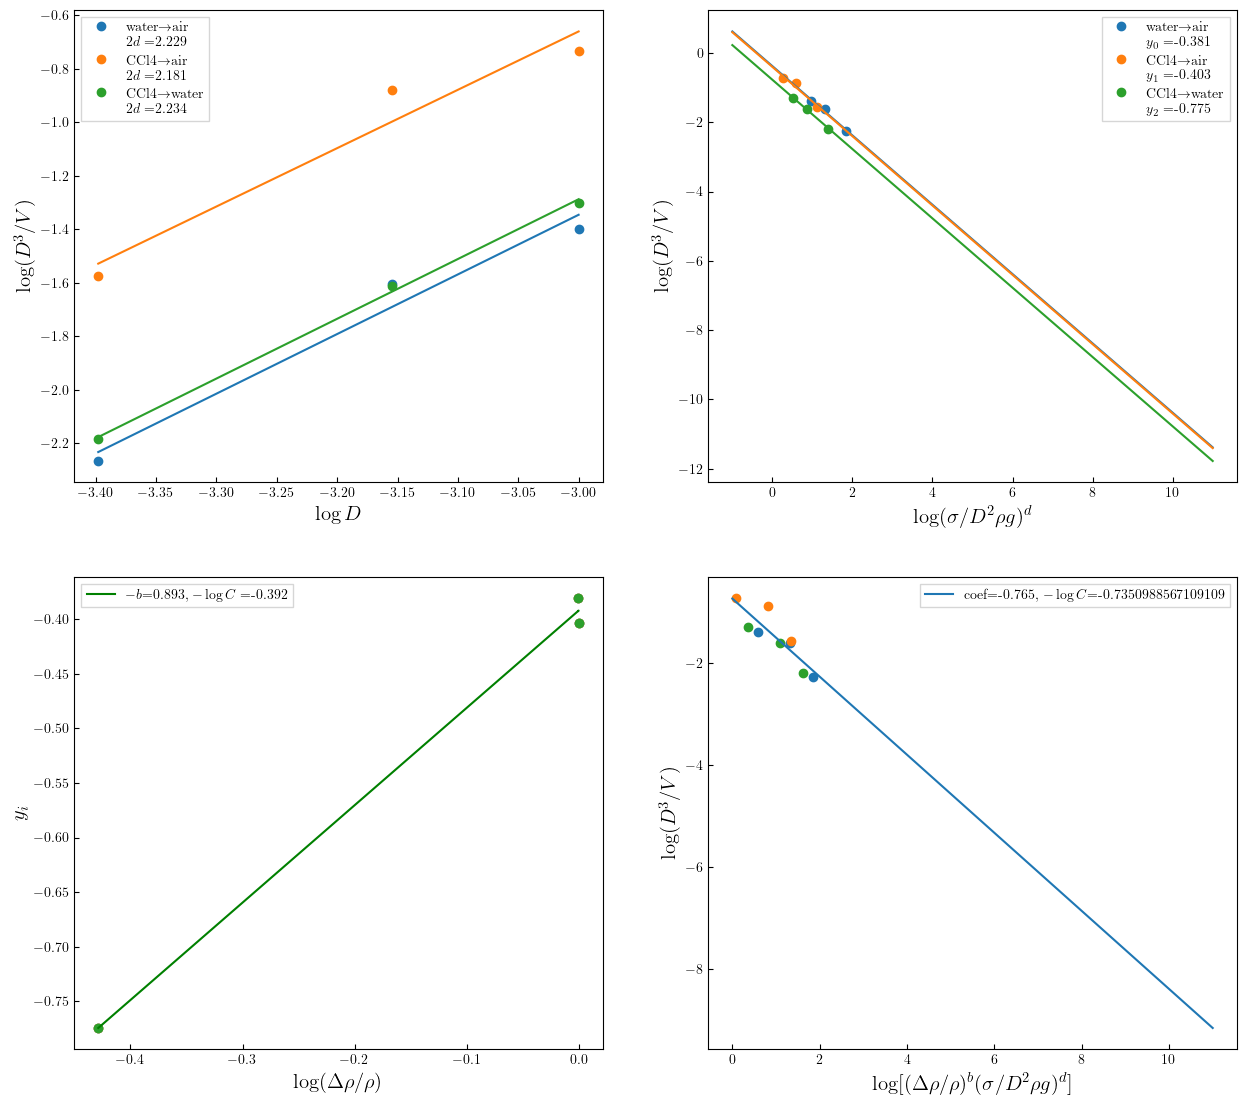

In [865]:
D = df['水-空気']['水→空気'].values
V = np.stack([df['水-空気']['2回目(未実施)'].values/df['水-空気']['液滴数'].values, 
              df['四塩化炭素-空気']['2回目(未実施)'].values/df['四塩化炭素-空気']['液滴数'].values,
              df['四塩化炭素-水']['2回目(未実施)'].values/df['四塩化炭素-水']['液滴数'].values])
logD = np.log10(D).reshape(-1,1)
logDV = np.log10(D**3/V).reshape(3,-1,1)

rho_r = np.array([1.2, 1.2, 1e3]) #連続相: 空気，　空気，　水
rho_b = np.array([1e3, 1.594e3, 1.594e3]) #分散相: 空気，　四塩化炭素，　四塩化炭素
drho = rho_b - rho_r
logrho = np.log10(drho/rho_b)

sigma = np.array([72e-3, 26.9e-3, 45e-3])
g = 9.81

b = 0
d = np.zeros(3)
y_i = np.zeros(3)
logsigma = np.zeros((3,3))
logrhosigma = np.zeros((3,3))

models = []
preds = []


for i in range(4): 
    model = []
    pred = []
    for j in range(3):
        if i==0: 
            model.append(linear_model.LinearRegression().fit(logD, logDV[j]))
            pred.append(model[j].predict(logD).reshape(-1))
            d[j] = model[j].coef_.item()/2
            logsigma[j] = np.log10((sigma[j]/(D**2*rho_b[j]*g))**d[j])
            
        if i==1: 
            model.append(linear_model.LinearRegression().fit(logsigma[j].reshape(-1,1), logDV[j]))
            pred.append(model[j].predict(np.arange(-1,12).reshape(-1,1)).reshape(-1))
            y_i[j] = model[j].predict(np.array(0).reshape(-1,1)).item()

        if i==2: 
            models.append(linear_model.LinearRegression().fit(logrho.reshape(-1,1), y_i.reshape(-1,1)))
            preds.append(models[i].predict(logrho.reshape(-1,1)).reshape(-1))
            b = models[i].coef_.item()
            for k in range(3):  
                logrhosigma[k] = np.log10((drho/rho_b)**b * (sigma[k]/(D**2*rho_b[j]*g))**d[k])
            break 

        if i==3: 
            models.append(linear_model.LinearRegression().fit(logrhosigma.reshape(-1,1), logDV.reshape(-1,1)))
            preds.append(models[i].predict(np.arange(0,12).reshape(-1,1)))
            break
            
        if j==2:    
            models.append(model)
            preds.append(pred)

fig, ax = plt.subplots(2,2, figsize=(15,13.5))
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titley'] = -0.17
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.fancybox'] = False


ss_font = {'family': 'cmss10'}

ax[0,0].set_xlabel(r"$\log D$")
ax[0,0].set_ylabel(r"$\log(D^3/V)$")
ax[0,1].set_xlabel(r"$\log(\sigma/D^2\rho g)^d$")
ax[0,1].set_ylabel(r"$\log(D^3/V)$")
ax[1,0].set_xlabel(r"$\log(\Delta\rho/\rho)$")
ax[1,0].set_ylabel(r"$y_i$")
ax[1,1].set_xlabel(r"$\log[(\Delta\rho/\rho)^b(\sigma/D^2\rho g)^d]$")
ax[1,1].set_ylabel(r"$\log(D^3/V)$")
labels = ["water$\\to$air", "CCl4$\\to$air", "CCl4$\\to$water"]

 
for i in range(3):
    ax[0,0].scatter(logD, logDV[i], label=labels[i]+f"\n$\\quad2d=${models[0][i].coef_.item():.3f}")
    ax[0,0].plot(logD, preds[0][i])
    ax[0,1].scatter(logsigma[i], logDV[i], label=labels[i]+f"\n$y_{i}=${y_i[i]:.3f}")
    ax[0,1].plot(np.arange(-1,12), preds[1][i])
    ax[1,0].scatter(logrho, y_i)
    
    ax[1,1].scatter(logrhosigma[i], logDV[i])

ax[1,0].plot(logrho, preds[2], 
             label=f"$-b$={models[2].coef_.item():.3f}"+
                   f", $-\log C=${models[2].predict(np.array(0).reshape(-1,1)).item():.3f}",
             color="green")
ax[1,1].plot(np.arange(0,12), preds[3], label=f"coef={models[3].coef_.item():.3f}"+
                                              f", $-\log C$={models[3].predict(np.array(0).reshape(-1,1)).item()}")

# ax[0,0].set_title("a", fontdict=ss_font)



for i in range(2): 
    for j in range(2): 
        ax[i,j].legend(scatteryoffsets=[1.54], prop={'family': 'Meiryo'})

fig.savefig("graph.pdf", bbox_inches="tight")

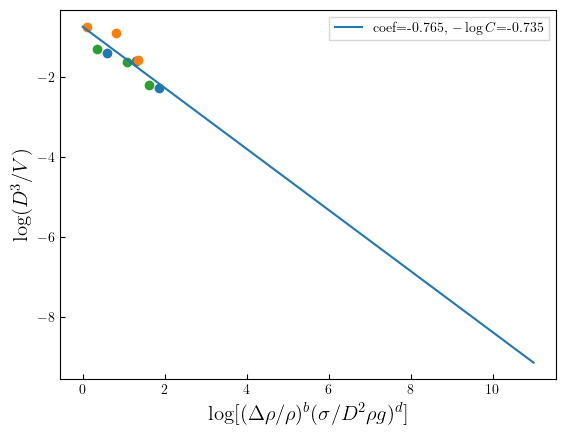

In [871]:
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titley'] = -0.17
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.fancybox'] = False


ss_font = {'family': 'cmss10'}


labels = ["water$\\to$air", "CCl4$\\to$air", "CCl4$\\to$water"]

 
for i in range(3):
    plt.scatter(logD, logDV[i], label=labels[i]+f"\n$\\quad2d=${models[0][i].coef_.item():.3f}")
    plt.plot(logD, preds[0][i])
plt.xlabel(r"$\log D$")
plt.ylabel(r"$\log(D^3/V)$")
plt.legend(scatteryoffsets=[1.4])
plt.savefig("graph0.pdf", bbox_inches="tight")
plt.close()

for i in range(3):
    plt.scatter(logsigma[i], logDV[i], label=labels[i]+f"\n$y_{i}=${y_i[i]:.3f}")
    plt.plot(np.arange(-1,12), preds[1][i])
plt.xlabel(r"$\log(\sigma/D^2\rho g)^d$")
plt.ylabel(r"$\log(D^3/V)$")
plt.legend(scatteryoffsets=[1.4])
plt.savefig("graph1.pdf", bbox_inches="tight")
plt.close()
    
plt.scatter(logrho, y_i)



plt.plot(logrho, preds[2], 
             label=f"$-b$={models[2].coef_.item():.3f}"+
                   f", $-\log C=${models[2].predict(np.array(0).reshape(-1,1)).item():.3f}")
plt.xlabel(r"$\log(\Delta\rho/\rho)$")
plt.ylabel(r"$y_i$")
plt.legend(scatteryoffsets=[1.4])
plt.savefig("graph2.pdf", bbox_inches="tight")
plt.close()

for i in range(3):
    plt.scatter(logrhosigma[i], logDV[i])
plt.plot(np.arange(0,12), preds[3], label=f"coef={models[3].coef_.item():.3f}"+
                                              f", $-\log C$={models[3].predict(np.array(0).reshape(-1,1)).item():.3f}")
plt.xlabel(r"$\log[(\Delta\rho/\rho)^b(\sigma/D^2\rho g)^d]$")
plt.ylabel(r"$\log(D^3/V)$")
plt.legend(scatteryoffsets=[1.4])
plt.savefig("graph3.pdf", bbox_inches="tight")
# plt.close()

# ax[0,0].set_title("a", fontdict=ss_font)




plt.legend(scatteryoffsets=[1.54], prop={'family': 'Meiryo'})